<a href="https://colab.research.google.com/github/melihkurtaran/MachineLearning/blob/main/FFNN%26RBFNN/FFNN%26RBFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Computational Intelligence - Feed-forward Neural Networks (FFNN) &
Radial Basis Functions Neural Networks (RBFNN)**

The dataset for this project consists of electrocardiogram signals (ECG) of heartbeats for the normal case (class label 0) and
four more cases affected by different arrhythmia and myocardial infarction (class labels 1 to 4). These signals
have been preprocessed and segmented, so that each segment is a heartbeat, and correspondingly one sample of
the dataset, which, in turn, consists of signal values for 187 time instants. Figure 1 shows one example for each
class

In [142]:
#Load libraries
import pandas as pd
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import SGD, Adagrad, Adadelta, RMSprop
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
#Connect to GitHub for faster access
!git clone https://github.com/melihkurtaran/MachineLearning.git

Cloning into 'MachineLearning'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 136 (delta 72), reused 43 (delta 17), pack-reused 0
Receiving objects: 100% (136/136), 4.36 MiB | 19.51 MiB/s, done.
Resolving deltas: 100% (72/72), done.


Read datasets

In [3]:
# Define the path to the datasets folder
folder = "MachineLearning/FFNN&RBFNN/datasets-nn/"

#defining a function to read files to datafame
def load_data(group, split, task):
    """Load the dataset for a given group, split, and task.

    Parameters:
        group (int): The group number.
        split (int): The split number.
        task (int): The task number (either 1 or 2).
    
    Returns:
        tuple: A tuple containing the training data (X_train, y_train) and the
            test data (X_test, y_test).
    """

    # Load the data for the given task and split
    data = pd.read_csv(folder + f'ds{task}-{group:02d}-{split}-nn-tr.csv')
    X_train = data.iloc[:, :-1].to_numpy()
    y_train = data.iloc[:, -1].to_numpy()
    data = pd.read_csv(folder + f'ds{task}-{group:02d}-{split}-nn-te.csv')
    X_test = data.iloc[:, :-1].to_numpy()
    y_test = data.iloc[:, -1].to_numpy()

    #printing only X for simplicity
    print(f'X_train_{task}_{group:02d}_sp{split} is created, size is {len(X_train)}')
    print(f'X_test_{task}_{group:02d}_sp{split} is created, size is {len(X_test)}')

    return (X_train, y_train), (X_test, y_test)

My group number is 11 and there are 3 splits

In [4]:
(X_train_1_sp1, y_train_1_sp1), (X_test_1_sp1, y_test_1_sp1) = load_data(11, 1, 1)
(X_train_1_sp2, y_train_1_sp2), (X_test_1_sp2, y_test_1_sp2) = load_data(11, 2, 1)
(X_train_1_sp3, y_train_1_sp3), (X_test_1_sp3, y_test_1_sp3) = load_data(11, 3, 1)

(X_train_2_sp1, y_train_2_sp1), (X_test_2_sp1, y_test_2_sp1) = load_data(11, 1, 2)
(X_train_2_sp2, y_train_2_sp2), (X_test_2_sp2, y_test_2_sp2) = load_data(11, 2, 2)
(X_train_2_sp3, y_train_2_sp3), (X_test_2_sp3, y_test_2_sp3) = load_data(11, 3, 2)

X_train_1_11_sp1 is created, size is 2503
X_test_1_11_sp1 is created, size is 1252
X_train_1_11_sp2 is created, size is 2503
X_test_1_11_sp2 is created, size is 1252
X_train_1_11_sp3 is created, size is 2504
X_test_1_11_sp3 is created, size is 1251
X_train_2_11_sp1 is created, size is 2666
X_test_2_11_sp1 is created, size is 1334
X_train_2_11_sp2 is created, size is 2667
X_test_2_11_sp2 is created, size is 1333
X_train_2_11_sp3 is created, size is 2667
X_test_2_11_sp3 is created, size is 1333


Visualizing one random sample electrocardiogram signal

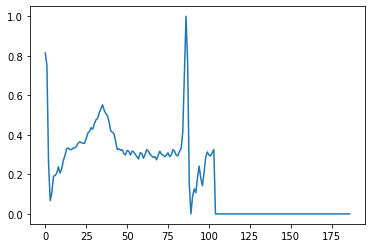

In [5]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the data as a line
ax.plot(X_train_1_sp1[784])

# Show the plot
plt.show()

A simple value count check for classes in one split of training data

In [6]:
# Count the occurrences of each value
counts = Counter(y_train_1_sp1)

# Print the counts of each value
for value, count in counts.items():
    print(f"Class {value}, count: {count}")

Class 0, count: 500
Class 1, count: 501
Class 2, count: 501
Class 3, count: 500
Class 4, count: 501


# **T1 - Design and evaluate an FFNN**

In [92]:
# Load and preprocess the data
X_train = np.concatenate((X_train_1_sp1, X_train_1_sp2,X_train_1_sp3))
y_train = np.concatenate((y_train_1_sp1, y_train_1_sp2,y_train_1_sp3))

X_test = np.concatenate((X_test_1_sp1, X_test_1_sp2,X_test_1_sp3))
y_test = np.concatenate((y_test_1_sp1, y_test_1_sp2,y_test_1_sp3))

num_classes = len(set(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## **a) Design**

An FFNN is developed to solve the multi-class classification problem

1. Start with a basic configuration: a single hidden layer network with enough neurons (1 and the most
basic activation function. For training, set a fixed learning rate, the most basic optimizer, a small
batch size and the most direct loss function. Tune the learning rate until you achieve convergence and
a reasonable performance. You can use the accuracy for measuring performance.

- Single hidden layer with 64 neurons used, 4 neurons reaching validation accuracy around 90% and 16 neurons reach 96% and 64 is reaching 98%

- Smaller batch size causes higher time for training but the validation accuracy is higher. It is set as 16 for starting.

- Both very low and very high learning rate have poor performance. Learning rate with the value 0.0001 gets 89% validation accuracy, learning rate with the value 0.1 causing model not to converge and the accuracy reach 90% but later decreases to 87%. Learning rate with the value 0.001 achieves convergence and reachs 98.7% validation accuracy

In [106]:
# Define the FFNN architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(len(X_train[0]),)))
model.add(Dense(num_classes, activation='softmax'))

# Define the optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/10
470/470 [==============================] - 1s 2ms/step - loss: 0.5856 - accuracy: 0.8280 - val_loss: 0.3095 - val_accuracy: 0.9052
Epoch 2/10
470/470 [==============================] - 1s 2ms/step - loss: 0.2461 - accuracy: 0.9272 - val_loss: 0.1896 - val_accuracy: 0.9435
Epoch 3/10
470/470 [==============================] - 1s 2ms/step - loss: 0.1623 - accuracy: 0.9490 - val_loss: 0.1310 - val_accuracy: 0.9603
Epoch 4/10
470/470 [==============================] - 1s 2ms/step - loss: 0.1227 - accuracy: 0.9601 - val_loss: 0.1037 - val_accuracy: 0.9688
Epoch 5/10
470/470 [==============================] - 1s 3ms/step - loss: 0.1001 - accuracy: 0.9672 - val_loss: 0.0881 - val_accuracy: 0.9763
Epoch 6/10
470/470 [==============================] - 1s 2ms/step - loss: 0.0852 - accuracy: 0.9726 - val_loss: 0.0719 - val_accuracy: 0.9790
Epoch 7/10
470/470 [==============================] - 1s 2ms/step - loss: 0.0737 - accuracy: 0.9760 - val_loss: 0.0717 - val_accuracy: 0.9752
Epoch 

2. Next, check whether a change in the activation function of the hidden layer neurons improve the
classification performance. If that is the case, keep with the alternative activation function.

- tanh: have very similar performance but a bit lower

- sigmoid: have clearly worse performance

- LeakyReLU: have very similar performance but a bit lower

- ELU: also have very similar performance but a bit lower

Since reLU had the best performance, we will keep it.

In [109]:
# Define the FFNN architecture
model = Sequential()
model.add(Dense(64, activation='sigmoid', input_shape=(len(X_train[0]),)))
model.add(Dense(num_classes, activation='softmax'))

# Define the optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/10
470/470 [==============================] - 2s 3ms/step - loss: 0.9770 - accuracy: 0.6987 - val_loss: 0.6220 - val_accuracy: 0.8485
Epoch 2/10
470/470 [==============================] - 1s 2ms/step - loss: 0.5078 - accuracy: 0.8497 - val_loss: 0.4347 - val_accuracy: 0.8586
Epoch 3/10
470/470 [==============================] - 1s 2ms/step - loss: 0.3962 - accuracy: 0.8702 - val_loss: 0.3604 - val_accuracy: 0.8740
Epoch 4/10
470/470 [==============================] - 1s 2ms/step - loss: 0.3422 - accuracy: 0.8800 - val_loss: 0.3195 - val_accuracy: 0.8881
Epoch 5/10
470/470 [==============================] - 1s 2ms/step - loss: 0.3046 - accuracy: 0.8953 - val_loss: 0.2826 - val_accuracy: 0.9044
Epoch 6/10
470/470 [==============================] - 1s 2ms/step - loss: 0.2731 - accuracy: 0.9075 - val_loss: 0.2558 - val_accuracy: 0.9105
Epoch 7/10
470/470 [==============================] - 1s 2ms/step - loss: 0.2455 - accuracy: 0.9160 - val_loss: 0.2340 - val_accuracy: 0.9230
Epoch 

3. Try now with a dynamic learning rate and keep it if the training improves (or does not get worse).

Value of epoch is increased to 20 from 10 and patience set as 1 to give more opportunity for dynamic learning rate to get updated. It is observed that learning rate got updated several times and the performance is slightly improved.

In [114]:
# Define the FFNN architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(len(X_train[0]),)))
model.add(Dense(num_classes, activation='softmax'))

# Define the callback
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=1, verbose=1)

# Define the optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), callbacks=[reduce_lr])

Epoch 1/20
470/470 [==============================] - 1s 2ms/step - loss: 0.6290 - accuracy: 0.8133 - val_loss: 0.3393 - val_accuracy: 0.8850 - lr: 0.0010
Epoch 2/20
470/470 [==============================] - 1s 2ms/step - loss: 0.2643 - accuracy: 0.9212 - val_loss: 0.2073 - val_accuracy: 0.9411 - lr: 0.0010
Epoch 3/20
470/470 [==============================] - 1s 2ms/step - loss: 0.1768 - accuracy: 0.9465 - val_loss: 0.1562 - val_accuracy: 0.9515 - lr: 0.0010
Epoch 4/20
470/470 [==============================] - 1s 2ms/step - loss: 0.1330 - accuracy: 0.9593 - val_loss: 0.1124 - val_accuracy: 0.9667 - lr: 0.0010
Epoch 5/20
470/470 [==============================] - 1s 2ms/step - loss: 0.1052 - accuracy: 0.9680 - val_loss: 0.0928 - val_accuracy: 0.9742 - lr: 0.0010
Epoch 6/20
470/470 [==============================] - 1s 2ms/step - loss: 0.0891 - accuracy: 0.9736 - val_loss: 0.0753 - val_accuracy: 0.9771 - lr: 0.0010
Epoch 7/20
470/470 [==============================] - 1s 2ms/step - lo

4. Change to an alternative optimizer and keep it if the performance gets better

- Stochastic Gradient Descent (SGD): Decreased the performance by 2-3%

- Adagrad: Decreased permormance very much, it dropped more than 10%

- Adadelta: Almost the same with Adam but lower for 1-2%

- RMSprop: Almost identical performance but a little lower.

Since there is no improvement by any of the alternative optimizers, Adam will be kept.

In [111]:
# Define the FFNN architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(len(X_train[0]),)))
model.add(Dense(num_classes, activation='softmax'))

# Define the callback
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=1, verbose=1)

# Change the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), callbacks=[reduce_lr])

Epoch 1/20
470/470 [==============================] - 1s 2ms/step - loss: 0.5677 - accuracy: 0.8276 - val_loss: 0.4025 - val_accuracy: 0.8618 - lr: 0.0010
Epoch 2/20
470/470 [==============================] - 1s 2ms/step - loss: 0.2772 - accuracy: 0.9061 - val_loss: 0.2496 - val_accuracy: 0.9180 - lr: 0.0010
Epoch 3/20
470/470 [==============================] - 1s 2ms/step - loss: 0.1982 - accuracy: 0.9350 - val_loss: 0.1697 - val_accuracy: 0.9411 - lr: 0.0010
Epoch 4/20
470/470 [==============================] - 1s 2ms/step - loss: 0.1495 - accuracy: 0.9530 - val_loss: 0.1469 - val_accuracy: 0.9507 - lr: 0.0010
Epoch 5/20
470/470 [==============================] - 1s 2ms/step - loss: 0.1211 - accuracy: 0.9627 - val_loss: 0.1289 - val_accuracy: 0.9603 - lr: 0.0010
Epoch 6/20
470/470 [==============================] - 1s 2ms/step - loss: 0.1029 - accuracy: 0.9658 - val_loss: 0.0895 - val_accuracy: 0.9704 - lr: 0.0010
Epoch 7/20
470/470 [==============================] - 1s 2ms/step - lo

5. Switch to another loss function to check whether the performance level increases.

None of the other loss functions did not improve the performance.

In [113]:
# Define the FFNN architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(len(X_train[0]),)))
model.add(Dense(num_classes, activation='softmax'))

# Define the callback
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=1, verbose=1)

# Define the optimizer
optimizer = Adam(learning_rate=0.001)

# Changing the loss function
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), callbacks=[reduce_lr])

Epoch 1/20
470/470 [==============================] - 2s 3ms/step - loss: 0.0586 - accuracy: 0.8300 - val_loss: 0.0344 - val_accuracy: 0.8991 - lr: 0.0010
Epoch 2/20
470/470 [==============================] - 1s 2ms/step - loss: 0.0253 - accuracy: 0.9296 - val_loss: 0.0197 - val_accuracy: 0.9462 - lr: 0.0010
Epoch 3/20
470/470 [==============================] - 1s 2ms/step - loss: 0.0176 - accuracy: 0.9502 - val_loss: 0.0146 - val_accuracy: 0.9630 - lr: 0.0010
Epoch 4/20
470/470 [==============================] - 1s 2ms/step - loss: 0.0137 - accuracy: 0.9623 - val_loss: 0.0134 - val_accuracy: 0.9630 - lr: 0.0010
Epoch 5/20
470/470 [==============================] - 1s 2ms/step - loss: 0.0117 - accuracy: 0.9674 - val_loss: 0.0107 - val_accuracy: 0.9686 - lr: 0.0010
Epoch 6/20
470/470 [==============================] - 1s 2ms/step - loss: 0.0101 - accuracy: 0.9711 - val_loss: 0.0083 - val_accuracy: 0.9798 - lr: 0.0010
Epoch 7/20
470/470 [==============================] - 1s 2ms/step - lo

6. Add a second hidden layer with a reasonable number of neurons and check whether a performance gain
is obtained. If that is the case, keep the second layer.

There is no improvement in the performance when having 2nd hidden layer, because of that 2nd layer is not added.

In [117]:
# Define the FFNN architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(len(X_train[0]),)))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Define the callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=1, verbose=1)

# Define the optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), callbacks=[reduce_lr])

Epoch 1/20
470/470 [==============================] - 1s 2ms/step - loss: 0.4749 - accuracy: 0.8466 - val_loss: 0.2076 - val_accuracy: 0.9348 - lr: 0.0010
Epoch 2/20
470/470 [==============================] - 1s 2ms/step - loss: 0.1705 - accuracy: 0.9423 - val_loss: 0.1419 - val_accuracy: 0.9470 - lr: 0.0010
Epoch 3/20
470/470 [==============================] - 1s 2ms/step - loss: 0.1148 - accuracy: 0.9589 - val_loss: 0.1219 - val_accuracy: 0.9521 - lr: 0.0010
Epoch 4/20
470/470 [==============================] - 1s 3ms/step - loss: 0.0882 - accuracy: 0.9691 - val_loss: 0.0756 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 5/20
470/470 [==============================] - ETA: 0s - loss: 0.0711 - accuracy: 0.9766
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
470/470 [==============================] - 1s 2ms/step - loss: 0.0711 - accuracy: 0.9766 - val_loss: 0.1508 - val_accuracy: 0.9529 - lr: 0.0010
Epoch 6/20
470/470 [==============================] - 1s 3ms/st

7. Increase the batch size. You should observe that the training time gets shorter and keep it if your
performance does not decrease

Batch size increased from 16 to 32. Altough increasing the batch size causes around 1-2% decrease in the performance. Training time gets much shorter. However, since validation accuracy is decreasing even for batch size value of 24, the batch size kept as 16.

In [118]:
# Define the FFNN architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(len(X_train[0]),)))
model.add(Dense(num_classes, activation='softmax'))

# Define the callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=1, verbose=1)

# Define the optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[reduce_lr])

Epoch 1/20
235/235 [==============================] - 2s 7ms/step - loss: 0.7250 - accuracy: 0.7864 - val_loss: 0.3909 - val_accuracy: 0.8860 - lr: 0.0010
Epoch 2/20
235/235 [==============================] - 1s 2ms/step - loss: 0.3195 - accuracy: 0.9091 - val_loss: 0.2530 - val_accuracy: 0.9318 - lr: 0.0010
Epoch 3/20
235/235 [==============================] - 0s 2ms/step - loss: 0.2239 - accuracy: 0.9385 - val_loss: 0.1888 - val_accuracy: 0.9443 - lr: 0.0010
Epoch 4/20
235/235 [==============================] - 0s 2ms/step - loss: 0.1739 - accuracy: 0.9493 - val_loss: 0.1526 - val_accuracy: 0.9577 - lr: 0.0010
Epoch 5/20
235/235 [==============================] - 1s 2ms/step - loss: 0.1424 - accuracy: 0.9562 - val_loss: 0.1278 - val_accuracy: 0.9595 - lr: 0.0010
Epoch 6/20
235/235 [==============================] - 0s 2ms/step - loss: 0.1205 - accuracy: 0.9651 - val_loss: 0.1194 - val_accuracy: 0.9606 - lr: 0.0010
Epoch 7/20
235/235 [==============================] - 0s 2ms/step - lo

## **b) Evaluate**

In [147]:
def plot_training_history(history):
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot the training and validation loss in the first subplot
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper right')

    # Plot the training and validation accuracy in the second subplot
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('Model accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='lower right')
    plt.show()


In [148]:
def create_and_train_FFNN(X_train, y_train, X_test, y_test, num_classes):
    # Define the FFNN architecture
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(len(X_train[0]),)))
    model.add(Dense(num_classes, activation='softmax'))

    # Define the callback
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=1, verbose=0)

    # Define the optimizer
    optimizer = Adam(learning_rate=0.001)

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model and store the training history
    history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), callbacks=[reduce_lr], verbose=0)

    return model, history

Showing that the training has achieved convergence in each case

### **Split 1**

Convergence achieved for split 1

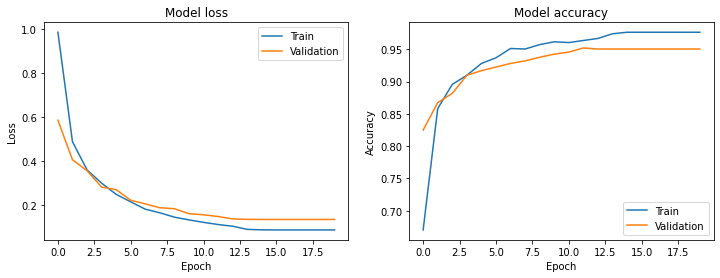

In [149]:
# Load and preprocess the data
X_train = X_train_1_sp1
y_train = y_train_1_sp1
X_test = X_test_1_sp1
y_test = y_test_1_sp1

num_classes = len(set(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

model, history = create_and_train_FFNN(X_train, y_train, X_test, y_test, num_classes)
plot_training_history(history)

Evaluating the network for split 1, reporting the confusion matrix
and providing the average value for the scoring metrics

In [150]:
predictions = model.predict(X_test)

# Convert predictions and true labels to binary values (0 or 1) for each class
predictions = np.round(predictions)
y_test = np.round(y_test)

# Generate a confusion matrix
confusion_mat = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

print("Confusion Matrix:")
print(confusion_mat)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


40/40 [==============================] - 0s 812us/step
Confusion Matrix:
[[240   7   0   2   2]
 [ 22 218   2   8   0]
 [  6   1 239   0   4]
 [  6   1   0 244   0]
 [  7   0   0   0 243]]
Accuracy: 0.9432907348242812
Precision: 0.9558648315708743
Recall: 0.9432907348242812
F1-score: 0.9489246372966347


### **Split 2**

Convergence achieved for split 2

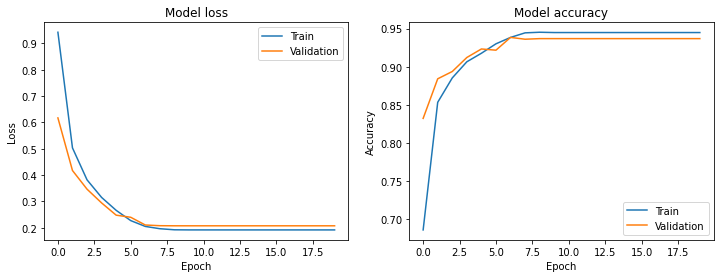

In [151]:
# Load and preprocess the data
X_train = X_train_1_sp2
y_train = y_train_1_sp2
X_test = X_test_1_sp2
y_test = y_test_1_sp2

num_classes = len(set(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

model, history = create_and_train_FFNN(X_train, y_train, X_test, y_test, num_classes)
plot_training_history(history)

Evaluating the network for split 2, reporting the confusion matrix
and providing the average value for the scoring metrics

In [152]:
predictions = model.predict(X_test)

# Convert predictions and true labels to binary values (0 or 1) for each class
predictions = np.round(predictions)
y_test = np.round(y_test)

# Generate a confusion matrix
confusion_mat = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

print("Confusion Matrix:")
print(confusion_mat)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


40/40 [==============================] - 0s 1ms/step
Confusion Matrix:
[[240   6   0   3   1]
 [ 14 224   5   8   0]
 [  8   8 230   1   3]
 [ 13   3   1 233   0]
 [  8   0   2   0 241]]
Accuracy: 0.9257188498402555
Precision: 0.9458918199105107
Recall: 0.9257188498402555
F1-score: 0.9355336198523385


### **Split 3**

Convergence achieved for split 3

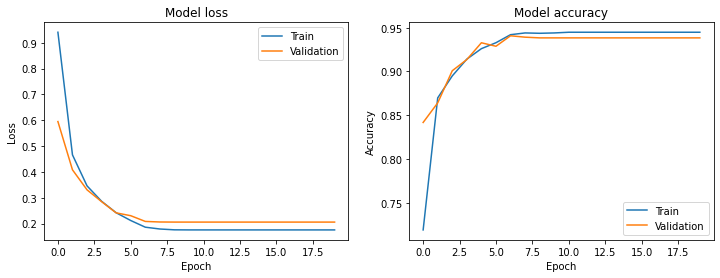

In [153]:
# Load and preprocess the data
X_train = X_train_1_sp3
y_train = y_train_1_sp3
X_test = X_test_1_sp3
y_test = y_test_1_sp3

num_classes = len(set(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

model, history = create_and_train_FFNN(X_train, y_train, X_test, y_test, num_classes)
plot_training_history(history)

Evaluating the network for split 3, reporting the confusion matrix
and providing the average value for the scoring metrics

In [154]:
predictions = model.predict(X_test)

# Convert predictions and true labels to binary values (0 or 1) for each class
predictions = np.round(predictions)
y_test = np.round(y_test)

# Generate a confusion matrix
confusion_mat = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')
f1 = f1_score(y_test, predictions, average='weighted')

print("Confusion Matrix:")
print(confusion_mat)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


40/40 [==============================] - 0s 1ms/step
Confusion Matrix:
[[234   9   4   3   0]
 [ 23 220   3   4   0]
 [  6   9 232   0   4]
 [  6   2   1 241   0]
 [  8   0   2   0 240]]
Accuracy: 0.9280575539568345
Precision: 0.9522725937618459
Recall: 0.9280575539568345
F1-score: 0.9399767958289957
